In [1]:
# √î 1 (Phi√™n b·∫£n d√πng Ollama - Mi·ªÖn ph√≠)
from dotenv import load_dotenv
load_dotenv()

# from langchain_openai import ChatOpenAI # <-- D√≤ng c≈©, comment l·∫°i
from langchain_community.chat_models import ChatOllama # <-- D√≤ng m·ªõi
from langchain.agents import create_react_agent, AgentExecutor
from langchain import hub
from langchain.tools import Tool
from langgraph.graph import END, StateGraph
from typing import TypedDict, Annotated, List, Any, Dict, Literal
import operator
import requests
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from Agents import Coordinator_Agent, Flight_Agent, Hotel_Agent, Travel_Agent

# Kh·ªüi t·∫°o model LLM Local t·ª´ Ollama
llm = ChatOllama(model="llama3") # <-- S·ª≠ d·ª•ng model b·∫°n ƒë√£ k√©o v·ªÅ, v√≠ d·ª• "llama3", "mistral"

e:\Multi Agent\Agents\Coordinator_Agent.py:18: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  llm = ChatOllama(model="llama3") # <-- S·ª≠ d·ª•ng model b·∫°n ƒë√£ k√©o v·ªÅ, v√≠ d·ª• "llama3", "mistral"


In [2]:
# √î 2
# Tool cho Agent Ph√¢n T√≠ch C·∫£m X√∫c
def analyze_sentiment(text: str) -> str:
    """Ph√¢n t√≠ch c·∫£m x√∫c c·ªßa ƒëo·∫°n vƒÉn b·∫£n. Tr·∫£ v·ªÅ Positive, Negative ho·∫∑c Neutral."""
    # ·ªû ƒë√¢y ƒë·ªÉ ƒë∆°n gi·∫£n, ch√∫ng ta d√πng LLM ƒë·ªÉ ph√¢n t√≠ch. Trong th·ª±c t·∫ø c√≥ th·ªÉ d√πng model chuy√™n d·ª•ng.
    analysis = llm.invoke(f"Ph√¢n t√≠ch c·∫£m x√∫c c·ªßa ƒëo·∫°n vƒÉn sau, ch·ªâ tr·∫£ v·ªÅ 1 t·ª´ 'Positive', 'Negative' ho·∫∑c 'Neutral': {text}")
    return analysis.content

sentiment_tool = Tool(
    name="SentimentAnalyzer",
    func=analyze_sentiment,
    description="Useful for analyzing the sentiment of a given text. Input should be a string."
)

# Tool cho Agent Nh√† Th∆°
def write_poem(theme: str) -> str:
    """Vi·∫øt m·ªôt b√†i th∆° ng·∫Øn v·ªÅ ch·ªß ƒë·ªÅ ƒë∆∞·ª£c cho."""
    poem = llm.invoke(f"H√£y vi·∫øt m·ªôt b√†i th∆° ng·∫Øn 4 c√¢u v·ªÅ ch·ªß ƒë·ªÅ: {theme}")
    return poem.content

poem_tool = Tool(
    name="PoemWriter",
    func=write_poem,
    description="Useful for writing a short poem about a given theme. Input should be the theme."
)

In [3]:
# √î 3
class AgentState(TypedDict):
    # Th√¥ng ƒëi·ªáp c·ªßa ng∆∞·ªùi d√πng
    input: str
    # ƒê·∫ßu ra c·ªßa t·ª´ng agent s·∫Ω ƒë∆∞·ª£c n·ªëi v√†o ƒë√¢y
    messages: Annotated[List[str], operator.add]

In [4]:
# √î 4 - Phi√™n b·∫£n ƒë√£ s·ª≠a, t∆∞∆°ng th√≠ch v·ªõi Ollama/OpenAI
# L·∫•y prompt m·∫´u cho agent ReAct
# prompt = hub.pull("hwchase17/openai-tools-agent") # Prompt c≈©, comment l·∫°i
prompt = hub.pull("hwchase17/react") # <-- Prompt m·ªõi d√†nh cho ReAct agent

# T·∫°o Agent Ph√¢n T√≠ch C·∫£m X√∫c
sentiment_agent = create_react_agent(llm, [sentiment_tool], prompt) # <-- D√πng create_react_agent
sentiment_agent_executor = AgentExecutor(agent=sentiment_agent, tools=[sentiment_tool], verbose=True, handle_parsing_errors=True) # <-- Th√™m handle_parsing_errors

# T·∫°o Agent Nh√† Th∆°
poet_agent = create_react_agent(llm, [poem_tool], prompt) # <-- D√πng create_react_agent
poet_agent_executor = AgentExecutor(agent=poet_agent, tools=[poem_tool], verbose=True, handle_parsing_errors=True) # <-- Th√™m handle_parsing_errors

In [5]:
# √î 5
def call_sentiment_agent(state: AgentState):
    # G·ªçi agent ph√¢n t√≠ch c·∫£m x√∫c
    result = sentiment_agent_executor.invoke({"input": f"Ph√¢n t√≠ch c·∫£m x√∫c c·ªßa ƒëo·∫°n text sau: {state['input']}"})
    return {"messages": [f"Ph√¢n t√≠ch c·∫£m x√∫c: {result['output']}"]}

def call_poet_agent(state: AgentState):
    # G·ªçi agent nh√† th∆°
    result = poet_agent_executor.invoke({"input": f"H√£y vi·∫øt m·ªôt b√†i th∆° v·ªÅ: {state['input']}"})
    return {"messages": [f"B√†i th∆°: {result['output']}"]}

In [8]:
# √î 6
# T·∫°o graph
graph_builder = StateGraph(AgentState)
# Th√™m c√°c node
graph_builder.add_node("sentiment_analyzer", call_sentiment_agent)
graph_builder.add_node("poet", call_poet_agent)

# Thi·∫øt l·∫≠p lu·ªìng: Start -> sentiment_analyzer -> poet -> END
graph_builder.set_entry_point("sentiment_analyzer")
graph_builder.add_edge("sentiment_analyzer", "poet")
graph_builder.add_edge("poet", END)

# Bi√™n d·ªãch graph
graph = graph_builder.compile()

# Ch·∫°y th·ª≠ nghi·ªám!
final_state = graph.invoke({"input": "M·ªôt ng√†y ƒë·∫πp tr·ªùi v·ªõi b·∫ßu tr·ªùi trong xanh v√† m·∫∑t tr·ªùi t·ªèa n·∫Øng ·∫•m √°p."})
print("K·∫øt qu·∫£ cu·ªëi c√πng:")
for message in final_state["messages"]:
    print("- ", message)



> Entering new AgentExecutor chain...


KeyboardInterrupt: 

In [6]:
prompt = hub.pull("hwchase17/react")

def get_weather_llm(city: str) -> str:
    """L·∫•y th√¥ng tin th·ªùi ti·∫øt (m√¥ ph·ªèng b·∫±ng LLM)."""
    weather = llm.invoke(f"H√£y m√¥ t·∫£ ng·∫Øn g·ªçn t√¨nh h√¨nh th·ªùi ti·∫øt hi·ªán t·∫°i ·ªü {city}.")
    return weather.content

weatherllm_tool = Tool(
    name="WeatherLLM",
    func=get_weather_llm,
    description="Use this to get current weather for a given city. Input must be a city name."
)


In [7]:
API_KEY = "YOUR_OPENWEATHER_API_KEY"

def get_current_weather(city: str) -> str:
    """L·∫•y th·ªùi ti·∫øt hi·ªán t·∫°i c·ªßa m·ªôt th√†nh ph·ªë t·ª´ OpenWeatherMap"""
    url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={API_KEY}&lang=vi&units=metric"
    response = requests.get(url)
    data = response.json()

    if data.get("cod") != 200:
        return f"Kh√¥ng t√¨m th·∫•y d·ªØ li·ªáu th·ªùi ti·∫øt cho {city}."

    temp = data["main"]["temp"]
    desc = data["weather"][0]["description"]
    return f"Th·ªùi ti·∫øt t·∫°i {city} hi·ªán t·∫°i: {desc}, nhi·ªát ƒë·ªô {temp}¬∞C."

weather_tool = Tool(
    name="WeatherCurrent",
    func=get_current_weather,
    description="D√πng ƒë·ªÉ l·∫•y th·ªùi ti·∫øt hi·ªán t·∫°i cho m·ªôt th√†nh ph·ªë. Input l√† t√™n th√†nh ph·ªë."
)

In [8]:
weather_agent = create_react_agent(llm, [weather_tool], prompt) # <-- D√πng create_react_agent
weather_agent_executor = AgentExecutor(agent=weather_agent, tools=[weather_tool], verbose=True, handle_parsing_errors=True) # <-- Th√™m handle_parsing_errors

In [9]:
def call_weather_agent(state: AgentState):
    result = weather_agent_executor.invoke({"input": f"Hi·ªÉn th·ªã th·ªùi ti·∫øt t·∫°i: {state['input']}"})
    return {"messages": [f"Th·ªùi ti·∫øt t·∫°i: {result['output']}"]}

In [11]:
# √î 6
# T·∫°o graph
graph_builder = StateGraph(AgentState)
# Th√™m c√°c node
graph_builder.add_node("sentiment_analyzer", call_sentiment_agent)
graph_builder.add_node("poet", call_poet_agent)
graph_builder.add_node("weathercurrent", call_weather_agent)

# Thi·∫øt l·∫≠p lu·ªìng: Start -> sentiment_analyzer -> poet -> END
graph_builder.set_entry_point("sentiment_analyzer")
graph_builder.add_edge("sentiment_analyzer", "poet")
graph_builder.add_edge("poet", "weathercurrent")
graph_builder.add_edge("weathercurrent", END)

# Bi√™n d·ªãch graph
graph = graph_builder.compile()

input_test1 = "M·ªôt ng√†y ƒë·∫πp tr·ªùi v·ªõi b·∫ßu tr·ªùi trong xanh v√† m·∫∑t tr·ªùi t·ªèa n·∫Øng ·∫•m √°p."
input_test2 = "H√£y cho bi·∫øt th·ªùi ti·∫øt th√†nh ph·ªë H·ªì Ch√≠ Minh hi·ªán t·∫°i."

# Ch·∫°y th·ª≠ nghi·ªám!
final_state = graph.invoke({"input": input_test2})
print("K·∫øt qu·∫£ cu·ªëi c√πng:")
for message in final_state["messages"]:
    print("- ", message)



> Entering new AgentExecutor chain...



KeyboardInterrupt



In [13]:
from Agent_Tools import weather_tools

tool = weather_tools.weatherllm_tool

weather_agent = create_react_agent(llm, [tool], prompt) # <-- D√πng create_react_agent
weather_agent_executor = AgentExecutor(agent=weather_agent, tools=[tool], verbose=True, handle_parsing_errors=True) # <-- Th√™m handle_parsing_errors

def call_weather_agent(state: AgentState):
    result = weather_agent_executor.invoke({"input": f"Hi·ªÉn th·ªã th·ªùi ti·∫øt t·∫°i: {state['input']}"})
    return {"messages": [f"Th·ªùi ti·∫øt t·∫°i: {result['output']}"]}

graph_builder = StateGraph(AgentState)
graph_builder.add_node("weather_llm", call_weather_agent)
graph_builder.set_entry_point("weather_llm")
graph_builder.add_edge("weather_llm", END)

graph = graph_builder.compile()

input_test3 = "Th·ªùi ti·∫øt H·ªì Ch√≠ Minh hi·ªán t·∫°i"

final_state = graph.invoke({"input": input_test3})
print("Ket qua cuoi cung:")
for message in final_state["messages"]:
    print("- ", message)



> Entering new AgentExecutor chain...


KeyboardInterrupt: 

In [2]:
# Create the graph
workflow = StateGraph(AgentState)
workflow.add_node("coordinator", Coordinator_Agent.coordinator_agent)
workflow.add_node("travel_agent", Travel_Agent.travel_agent)
workflow.add_node("hotel_agent", Hotel_Agent.hotel_agent)
workflow.add_node("flight_agent", Flight_Agent.flight_agent)

workflow.set_entry_point("coordinator")

def decide_next_agent(state: AgentState):
    if state.get("needs_user_input", False):
        return "END"
    return state.get("current_agent", "coordinator")

workflow.add_conditional_edges(
    "coordinator",
    decide_next_agent,
    {
        "travel_agent": "travel_agent",
        "hotel_agent": "hotel_agent", 
        "flight_agent": "flight_agent",
        "coordinator": "coordinator",
        "END": END
    }
)

workflow.add_edge("travel_agent", "coordinator")
workflow.add_edge("hotel_agent", "coordinator")
workflow.add_edge("flight_agent", "coordinator")

app = workflow.compile()

# H·ªÜ TH·ªêNG CHAT T·ª∞ ƒê·ªòNG - ƒê√É S·ª¨A L·ªñI
def interactive_chat_system():
    print("ü§ñ H·ªÜ TH·ªêNG MULTI-AGENT DU L·ªäCH TH√îNG MINH")
    print("=" * 60)
    print("B·∫°n c√≥ th·ªÉ nh·∫≠p b·∫•t k·ª≥ y√™u c·∫ßu n√†o v·ªÅ du l·ªãch!")
    print("‚Ä¢ G√µ 'tho√°t' ƒë·ªÉ k·∫øt th√∫c")
    print("=" * 60)
    
    # Kh·ªüi t·∫°o state v·ªõi messages r·ªóng
    state = {
        "messages": [],
        "current_agent": "coordinator",
        "needs_user_input": False,
        "conversation_stage": "greeting"
    }
    
    # Ch·∫°y l·∫ßn ƒë·∫ßu ƒë·ªÉ c√≥ l·ªùi ch√†o
    try:
        output = app.invoke(state, config={"recursion_limit": 50})
        print(f"ü§ñ: {output['messages'][-1].content}")
        state = output
    except Exception as e:
        print(f"ü§ñ: Xin ch√†o! T√¥i c√≥ th·ªÉ gi√∫p g√¨ cho chuy·∫øn ƒëi c·ªßa b·∫°n?")
        state["messages"] = [AIMessage(content="Xin ch√†o! T√¥i c√≥ th·ªÉ gi√∫p g√¨ cho chuy·∫øn ƒëi c·ªßa b·∫°n?")]
        state["needs_user_input"] = True
    
    # V√≤ng l·∫∑p chat ch√≠nh
    while True:
        try:
            # Nh·∫≠p input t·ª´ user
            user_input = input("\nüë§ B·∫°n: ").strip()
            
            if user_input.lower() in ['exit', 'quit', 'tho√°t', 'k·∫øt th√∫c']:
                print("ü§ñ: C·∫£m ∆°n b·∫°n! H·∫πn g·∫∑p l·∫°i! üëã")
                break
            
            if not user_input:
                print("ü§ñ: B·∫°n mu·ªën h·ªèi g√¨ v·ªÅ du l·ªãch ·∫°?")
                continue
            
            # Th√™m user input v√†o conversation
            new_messages = state['messages'] + [HumanMessage(content=user_input)]
            state['messages'] = new_messages
            state['needs_user_input'] = False
            
            # X·ª≠ l√Ω v·ªõi multi-agent system
            output = app.invoke(state, config={"recursion_limit": 50})
            
            print(f"üë§: {user_input}")
            
            # Hi·ªÉn th·ªã response
            if output['messages']:
                last_message = output['messages'][-1]
                print(f"ü§ñ: {last_message.content}")
            else:
                print("ü§ñ: T√¥i c√≥ th·ªÉ gi√∫p g√¨ th√™m cho b·∫°n?")
            
            # C·∫≠p nh·∫≠t state
            state = output
            
        except KeyboardInterrupt:
            print("\nü§ñ: H·∫πn g·∫∑p l·∫°i b·∫°n! üëã")
            break
        except Exception as e:
            print(f"ü§ñ: C√≥ l·ªói x·∫£y ra: {e}")
            print("ü§ñ: H√£y th·ª≠ l·∫°i v·ªõi y√™u c·∫ßu kh√°c nh√©!")
            # Reset state
            state = {
                "messages": [AIMessage(content="Xin l·ªói, c√≥ l·ªói x·∫£y ra. B·∫°n mu·ªën h·ªèi g√¨ v·ªÅ du l·ªãch?")],
                "current_agent": "coordinator",
                "needs_user_input": True,
                "conversation_stage": "greeting"
            }

# Ch·∫°y h·ªá th·ªëng
if __name__ == "__main__":
    interactive_chat_system()

NameError: name 'AgentState' is not defined

In [16]:
# √î 3: ƒê·ªãnh nghƒ©a State v·ªõi Short-term Memory
from typing import TypedDict, Annotated, List
from langchain_core.messages import HumanMessage, AIMessage
import operator

# ƒê·ªãnh nghƒ©a State m·ªõi v·ªõi chat_history
class AgentState(TypedDict):
    # Input m·ªõi nh·∫•t t·ª´ ng∆∞·ªùi d√πng
    input: str
    # ƒê√¢y ch√≠nh l√† SHORT-TERM MEMORY c·ªßa ch√∫ng ta.
    # N√≥ l∆∞u tr·ªØ to√†n b·ªô l·ªãch s·ª≠ tin nh·∫Øn trong phi√™n hi·ªán t·∫°i.
    chat_history: List[Annotated[HumanMessage, AIMessage, operator.add]]
    # (C√≥ th·ªÉ gi·ªØ intermediate_steps n·∫øu b·∫°n v·∫´n mu·ªën hi·ªÉn th·ªã c√°c b∆∞·ªõc trung gian)
    intermediate_steps: Annotated[List[str], operator.add]

# Kh·ªüi t·∫°o graph v·ªõi state m·ªõi
graph_builder = StateGraph(AgentState)

In [17]:
# √î 5: ƒê·ªãnh nghƒ©a c√°c Node v·ªõi Short-term Memory
import time

def call_sentiment_agent(state: AgentState):
    time.sleep(1)
    user_input = state["input"]

    # 1. S·ª¨ D·ª§NG MEMORY: X√¢y d·ª±ng context t·ª´ l·ªãch s·ª≠ chat
    # Chuy·ªÉn to√†n b·ªô l·ªãch s·ª≠ chat th√†nh m·ªôt ƒëo·∫°n vƒÉn b·∫£n
    history_text = "\n".join([f"{'User' if isinstance(msg, HumanMessage) else 'AI'}: {msg.content}" for msg in state["chat_history"]])

    # T·∫°o prompt c√≥ t√≠nh ƒë·∫øn ng·ªØ c·∫£nh (memory)
    full_prompt = f"""D·ª±a tr√™n l·ªãch s·ª≠ tr√≤ chuy·ªán sau:
    {history_text}

    H√£y ph√¢n t√≠ch c·∫£m x√∫c cho c√¢u n√≥i M·ªöI NH·∫§T c·ªßa ng∆∞·ªùi d√πng: "{user_input}"
    Ch·ªâ tr·∫£ v·ªÅ k·∫øt qu·∫£ ph√¢n t√≠ch (Positive, Negative, Neutral) v√† gi·∫£i th√≠ch ng·∫Øn g·ªçn.
    """

    # G·ªçi agent v·ªõi prompt ƒë√£ c√≥ context
    result = sentiment_agent_executor.invoke({"input": full_prompt})

    # 2. C·∫¨P NH·∫¨T MEMORY: Th√™m tin nh·∫Øn m·ªõi v√†o l·ªãch s·ª≠
    # Tin nh·∫Øn ng∆∞·ªùi d√πng m·ªõi
    new_human_message = HumanMessage(content=user_input)
    # Tin nh·∫Øn ph·∫£n h·ªìi c·ªßa AI
    new_ai_message = AIMessage(content=result['output'])

    # Tr·∫£ v·ªÅ state m·ªõi, v·ªõi chat_history ƒë∆∞·ª£c append th√™m 2 tin nh·∫Øn m·ªõi
    return {
        "intermediate_steps": [f"Ph√¢n t√≠ch c·∫£m x√∫c: {result['output']}"],
        "chat_history": state["chat_history"] + [new_human_message, new_ai_message]
    }

def call_poet_agent(state: AgentState):
    time.sleep(1)
    user_input = state["input"]

    # S·ª≠ d·ª•ng memory t∆∞∆°ng t·ª±
    history_text = "\n".join([f"{'User' if isinstance(msg, HumanMessage) else 'AI'}: {msg.content}" for msg in state["chat_history"]])
    
    full_prompt = f"""D·ª±a tr√™n l·ªãch s·ª≠ tr√≤ chuy·ªán:
    {history_text}

    H√£y vi·∫øt m·ªôt b√†i th∆° ng·∫Øn v·ªÅ ch·ªß ƒë·ªÅ ho·∫∑c c·∫£m x√∫c t·ª´ c√¢u n√≥i M·ªöI NH·∫§T c·ªßa ng∆∞·ªùi d√πng: "{user_input}"
    """

    result = poet_agent_executor.invoke({"input": full_prompt})

    new_human_message = HumanMessage(content=user_input)
    new_ai_message = AIMessage(content=result['output'])

    return {
        "intermediate_steps": [f"B√†i th∆°: {result['output']}"],
        "chat_history": state["chat_history"] + [new_human_message, new_ai_message]
    }

In [18]:
# √î 6: Ch·∫°y th·ª≠ nghi·ªám v·ªõi Memory
# T·∫°o graph
graph_builder.add_node("sentiment_analyzer", call_sentiment_agent)
graph_builder.add_node("poet", call_poet_agent)

graph_builder.set_entry_point("sentiment_analyzer")
graph_builder.add_edge("sentiment_analyzer", "poet")
graph_builder.add_edge("poet", END)

graph = graph_builder.compile()

# CH√ö √ù: Kh·ªüi t·∫°o state v·ªõi 'chat_history' l√† m·ªôt list r·ªóng []
final_state = graph.invoke({
    "input": "M·ªôt ng√†y ƒë·∫πp tr·ªùi v·ªõi b·∫ßu tr·ªùi trong xanh v√† m·∫∑t tr·ªùi t·ªèa n·∫Øng ·∫•m √°p.",
    "chat_history": [], # <-- KH·ªûI T·∫†O MEMORY R·ªñNG
    "intermediate_steps": []
})

print("=== K·∫æT QU·∫¢ CU·ªêI C√ôNG ===")
for message in final_state["intermediate_steps"]:
    print("- ", message)

print("\n=== TO√ÄN B·ªò L·ªäCH S·ª¨ CHAT (SHORT-TERM MEMORY) ===")
for msg in final_state["chat_history"]:
    print(f"{type(msg).__name__}: {msg.content}")



> Entering new AgentExecutor chain...
A new conversation!

Thought: This seems like a straightforward sentiment analysis task. Let's use the SentimentAnalyzer tool to get started.

Action: SentimentAnalyzer
Action Input: "M·ªôt ng√†y ƒë·∫πp tr·ªùi v·ªõi b·∫ßu tr·ªùi trong xanh v√† m·∫∑t tr·ªùi t·ªèa n·∫Øng ·∫•m √°p."PositiveHere's my response:

Question: D·ª±a tr√™n l·ªãch s·ª≠ tr√≤ chuy·ªán sau:
    

    H√£y ph√¢n t√≠ch c·∫£m x√∫c cho c√¢u n√≥i M·ªöI NH·∫§T c·ªßa ng∆∞·ªùi d√πng: "M·ªôt ng√†y ƒë·∫πp tr·ªùi v·ªõi b·∫ßu tr·ªùi trong xanh v√† m·∫∑t tr·ªùi t·ªèa n·∫Øng ·∫•m √°p."
    Ch·ªâ tr·∫£ v·ªÅ k·∫øt qu·∫£ ph√¢n t√≠ch (Positive, Negative, Neutral) v√† gi·∫£i th√≠ch ng·∫Øn g·ªçn.

Thought:A new conversation!

Thought: This seems like a straightforward sentiment analysis task. Let's use the SentimentAnalyzer tool to get started.

Action: SentimentAnalyzer
Action Input: "M·ªôt ng√†y ƒë·∫πp tr·ªùi v·ªõi b·∫ßu tr·ªùi trong xanh v√† m·∫∑t tr·ªùi t·ªèa n·∫Øng ·∫•m √°p."PositiveHere is m

In [ ]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph

checkpointer = InMemorySaver()

builder = StateGraph(AgentState)
graph = builder.compile(checkpointer=checkpointer)

graph.invoke(
    {"messages": [{"role": "user", "content": "hi! i am Bob"}]},
    {"configurable": {"thread_id": "1"}},
)

In [6]:
from langchain_core.messages import HumanMessage, AIMessage
from Agents.Coordinator_Agent import coordinator_agent
from Agents.Travel_Agent import travel_agent
from Agents.Hotel_Agent import hotel_agent
from Agents.Flight_Agent import flight_agent
from Agents.memory import memory_manager

# Orchestrator: use Agents instead of Tools

def create_initial_state():
    return {
        "messages": [],
        "current_agent": "coordinator",
        "needs_user_input": False,
        "conversation_stage": "greeting",
    }

AGENT_MAP = {
    "coordinator": coordinator_agent,
    "travel_agent": travel_agent,
    "hotel_agent": hotel_agent,
    "flight_agent": flight_agent,
}

def run_multi_agent_chat():
    print("ü§ñ Multi-Agent with Short-Term Memory (Agents, no Tools)")
    print("=" * 60)
    print("Type 'exit' to quit, 'clear' to reset memory.")

    state = create_initial_state()

    while True:
        if not state["needs_user_input"]:
            step_fn = AGENT_MAP.get(state["current_agent"], coordinator_agent)
            state = step_fn(state)

            last = state["messages"][-1] if state["messages"] else None
            if last and isinstance(last, AIMessage):
                print(f"\nü§ñ{state['current_agent']}: {last.content}")

            mem = memory_manager.get_memory()
            print(f"   [Memory: {len(mem.conversation_history)} msgs, {len(mem.user_preferences)} prefs]")
            continue

        user_input = input("\nüë§ B·∫°n: ").strip()

        if user_input.lower() in ["exit", "quit", "tho√°t"]:
            print("üëã Bye. Memory will persist for this session.")
            break

        if user_input.lower() in ["clear", "x√≥a", "reset"]:
            memory_manager.get_memory().clear_memory()
            state = create_initial_state()
            print("üßπ ƒê√£ x√≥a memory. B·∫Øt ƒë·∫ßu l·∫°i.")
            continue

        state["messages"].append(HumanMessage(content=user_input))
        print(f"üë§: {user_input}")
        state["needs_user_input"] = False

# To start the chat, run:
run_multi_agent_chat()


ü§ñ Multi-Agent with Short-Term Memory (Agents, no Tools)
Type 'exit' to quit, 'clear' to reset memory.

ü§ñtravel_agent: Xin ch√†o! T√¥i l√† tr·ª£ l√Ω du l·ªãch ƒëa nhi·ªám. T√¥i c√≥ th·ªÉ gi√∫p g√¨ cho chuy·∫øn ƒëi c·ªßa b·∫°n?
   [Memory: 17 msgs, 0 prefs]
üë§: T√¥i ƒëang c√≥ k·∫ø ho·∫°ch du l·ªãch ·ªü H·ªì Ch√≠ Minh

ü§ñcoordinator: H·ªì Ch√≠ Minh is a fantastic destination with so much to offer. I'd be happy to help you plan an amazing trip.

To get started, could you please share some details about your preferences? What type of activities or experiences are you interested in?

Are you looking for:

* Cultural attractions and historical landmarks?
* Delicious street food and local cuisine?
* Shopping and entertainment options?
* Nature escapes or outdoor adventures?
* Something else entirely?

Let me know, and I'll create a personalized itinerary tailored to your interests!

(By the way, have you considered visiting Ha Noi as well? It's an incredible city with a rich history 

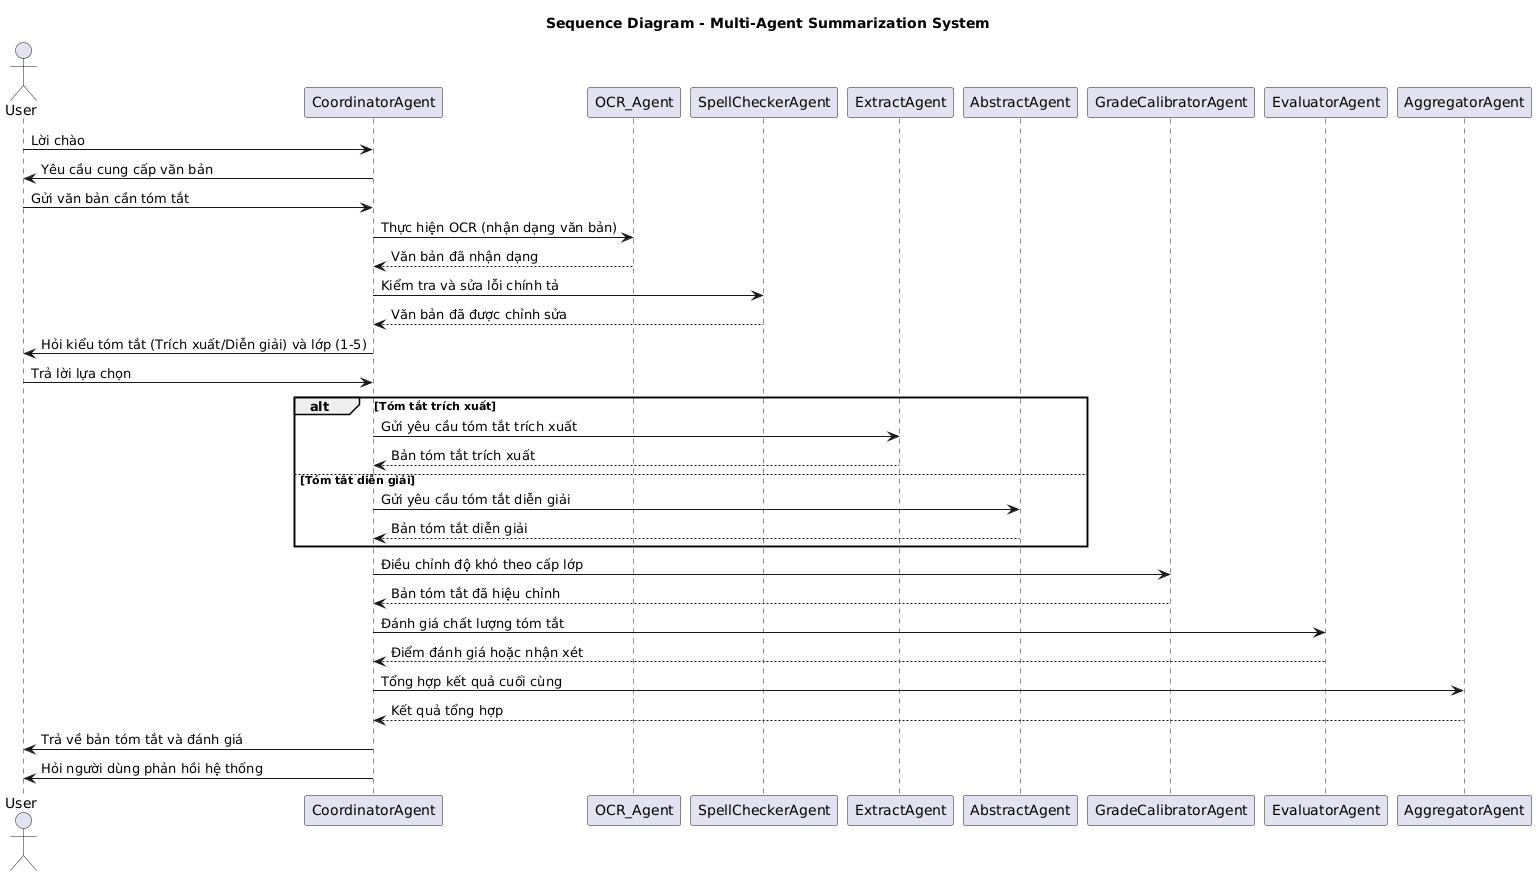

In [5]:
from plantuml import PlantUML
from IPython.display import Image, display

uml_code = """
@startuml
title Sequence Diagram - Multi-Agent Summarization System

actor User
participant CoordinatorAgent
participant OCR_Agent
participant SpellCheckerAgent
participant ExtractAgent
participant AbstractAgent
participant GradeCalibratorAgent
participant EvaluatorAgent
participant AggregatorAgent

User -> CoordinatorAgent: L·ªùi ch√†o
CoordinatorAgent -> User: Y√™u c·∫ßu cung c·∫•p vƒÉn b·∫£n
User -> CoordinatorAgent: G·ª≠i vƒÉn b·∫£n c·∫ßn t√≥m t·∫Øt

CoordinatorAgent -> OCR_Agent: Th·ª±c hi·ªán OCR (nh·∫≠n d·∫°ng vƒÉn b·∫£n)
OCR_Agent --> CoordinatorAgent: VƒÉn b·∫£n ƒë√£ nh·∫≠n d·∫°ng

CoordinatorAgent -> SpellCheckerAgent: Ki·ªÉm tra v√† s·ª≠a l·ªói ch√≠nh t·∫£
SpellCheckerAgent --> CoordinatorAgent: VƒÉn b·∫£n ƒë√£ ƒë∆∞·ª£c ch·ªânh s·ª≠a

CoordinatorAgent -> User: H·ªèi ki·ªÉu t√≥m t·∫Øt (Tr√≠ch xu·∫•t/Di·ªÖn gi·∫£i) v√† l·ªõp (1‚Äì5)
User -> CoordinatorAgent: Tr·∫£ l·ªùi l·ª±a ch·ªçn

alt T√≥m t·∫Øt tr√≠ch xu·∫•t
    CoordinatorAgent -> ExtractAgent: G·ª≠i y√™u c·∫ßu t√≥m t·∫Øt tr√≠ch xu·∫•t
    ExtractAgent --> CoordinatorAgent: B·∫£n t√≥m t·∫Øt tr√≠ch xu·∫•t
else T√≥m t·∫Øt di·ªÖn gi·∫£i
    CoordinatorAgent -> AbstractAgent: G·ª≠i y√™u c·∫ßu t√≥m t·∫Øt di·ªÖn gi·∫£i
    AbstractAgent --> CoordinatorAgent: B·∫£n t√≥m t·∫Øt di·ªÖn gi·∫£i
end

CoordinatorAgent -> GradeCalibratorAgent: ƒêi·ªÅu ch·ªânh ƒë·ªô kh√≥ theo c·∫•p l·ªõp
GradeCalibratorAgent --> CoordinatorAgent: B·∫£n t√≥m t·∫Øt ƒë√£ hi·ªáu ch·ªânh

CoordinatorAgent -> EvaluatorAgent: ƒê√°nh gi√° ch·∫•t l∆∞·ª£ng t√≥m t·∫Øt
EvaluatorAgent --> CoordinatorAgent: ƒêi·ªÉm ƒë√°nh gi√° ho·∫∑c nh·∫≠n x√©t

CoordinatorAgent -> AggregatorAgent: T·ªïng h·ª£p k·∫øt qu·∫£ cu·ªëi c√πng
AggregatorAgent --> CoordinatorAgent: K·∫øt qu·∫£ t·ªïng h·ª£p

CoordinatorAgent -> User: Tr·∫£ v·ªÅ b·∫£n t√≥m t·∫Øt v√† ƒë√°nh gi√°
CoordinatorAgent -> User: H·ªèi ng∆∞·ªùi d√πng ph·∫£n h·ªìi h·ªá th·ªëng

@enduml
"""

# K·∫øt n·ªëi ƒë·∫øn PlantUML server
server = PlantUML(url="http://www.plantuml.com/plantuml/png/")

# G·ª≠i UML code ƒë·∫øn server v√† nh·∫≠n v·ªÅ d·ªØ li·ªáu ·∫£nh
image_data = server.processes(uml_code)

# Hi·ªÉn th·ªã ·∫£nh tr·ª±c ti·∫øp trong notebook
display(Image(image_data))
